<a href="https://colab.research.google.com/github/alpyesilgul/cycleGAN/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Merhaba** , Bugün cycleGAN ağını tanıyalım ki bu yine Kaggle da haftalık TPU üzerinde 30 saatlik eğitim kazanmamızı sağlayan bir diğer başlangıç yarışması.

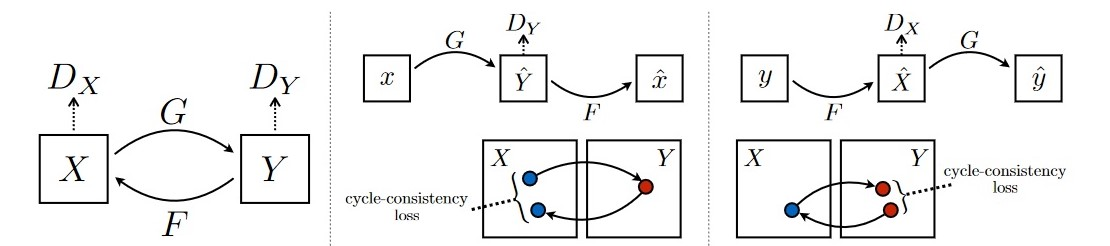

GAN mimarisi temelde [oyun teorisi](https://tr.wikipedia.org/wiki/Oyun_teorisi)ne dayanmaktadır. Modele üretmek istediğiniz veriden yeterli sayıda örnek verirseniz yine aynı veri tipinde yeni örnekler ürettirebilirsiniz. Sisteme binlerce kuş fotoğrafı verirseniz sistem, bir kuşun nasıl görünmesi gerektiğini öğrenecek ve yeni kuş fotoğrafları üretecektir. GAN’lerde birbiriyle çekişme halinde bulunan 2 farklı yapay sinir ağı bulunmaktadır. Bunlar Üretici (Generator) ve Ayırt Edici (Discriminator) ağ olarak adlandırılır. GAN mimarisi ile ilgili daha detaylı bilgilendirmeyi [buradan](https://cihanongun.medium.com/generative-adversarial-networks-gan-nedir-5cc6a48a6870) bulabilirsiniz. Peki biz ne yapacağız ? Dante misali cehennemin derinliklerinde Monet'i aramayacağız :) Bunun yerine ağımızı Monet resimleri ile eğiterek amatör bi Monet olmaya çalışıcağız. Ağın detaylarına girmek istemiyorum fakat bu [linkte](https://thispersondoesnotexist.com/) nVIDIA'nın GAN mimarisyle oluşturduğu hiç var olmayan insanları görebilirsiniz :)

In [ ]:
# Önce yardımcı fonksiyonlarımızı oluşturalım.
IMAGE_SIZE = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) # Görüntüyü uint8'e çevirelim.
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # Daha sonra bu görüntüyü önce flaot32'e çevirelim ve normalize edelim.  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # Görüntüyü yeniden boyutlandıralım.
    return image
# pipeline oluşturmak için TFRecord formatını kullanmak daha kullanışlıdır. İsterseniz görüntüleri de kullanabilirsiniz
def read_tfrecord(example): 
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),# Feature-Key'leri oluşturalım.
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format) # Datayı bölümleyelim.
    image = decode_image(example['image'])
    return image

# Datayı çoğaltma(augment) işlemi uygulayalım.
def augment_image(image):
    flip_image = tf.image.random_flip_left_right(image)
    return flip_image
# Son olarak da TFRec formatlı dataları okumak için bir fonksiyon oluşturalım.
def load_dataset(filenames, labeled=True, ordered=False, augment=False): 
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat(count=2)
    return dataset

Detaylı bilgilendirmeye elimden geldiğince girmemeye çalışıyorum. Bunlara göz atarken tfds, augmention etc. gibi teknikleri bildiğinizi düşünüyorum.

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Dosyalar büyük olduğunda burda drive'ıma bağlandım.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# Şimdi dosyaları içe aktaralım.
MONET_FILE = '/content/drive/MyDrive/ColabNotebooks/monet/*.tfrec'
PHOTO_FILE = '/content/drive/MyDrive/ColabNotebooks/photo/*.tfrec'
MONET = tf.io.gfile.glob(MONET_FILE)
PHOTO = tf.io.gfile.glob(PHOTO_FILE)
monet = load_dataset(MONET, augment=True).batch(1)
photo = load_dataset(PHOTO, augment=True).batch(1)

In [ ]:
# Doğruluklarını kontrol edelim
import matplotlib.pyplot as plt
test_monet = next(iter(monet))
test_photo = next(iter(photo))

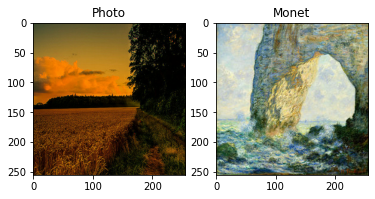

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(test_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(test_monet[0] * 0.5 + 0.5)

In [ ]:
# InstanceNormalization katmanı için bu package'ı yükleyelim
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 19.4MB/s 


In [ ]:
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
# Şimdi downsmaple ve upsample oluşturucumuzu oluşturalım.
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
# Geldik Generator ağına :)
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
   
    x = inputs

# Katmanları birbirine bağlayalım ve downsample'larımızı terse çevirelim.
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])


    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
from keras.utils.vis_utils import plot_model

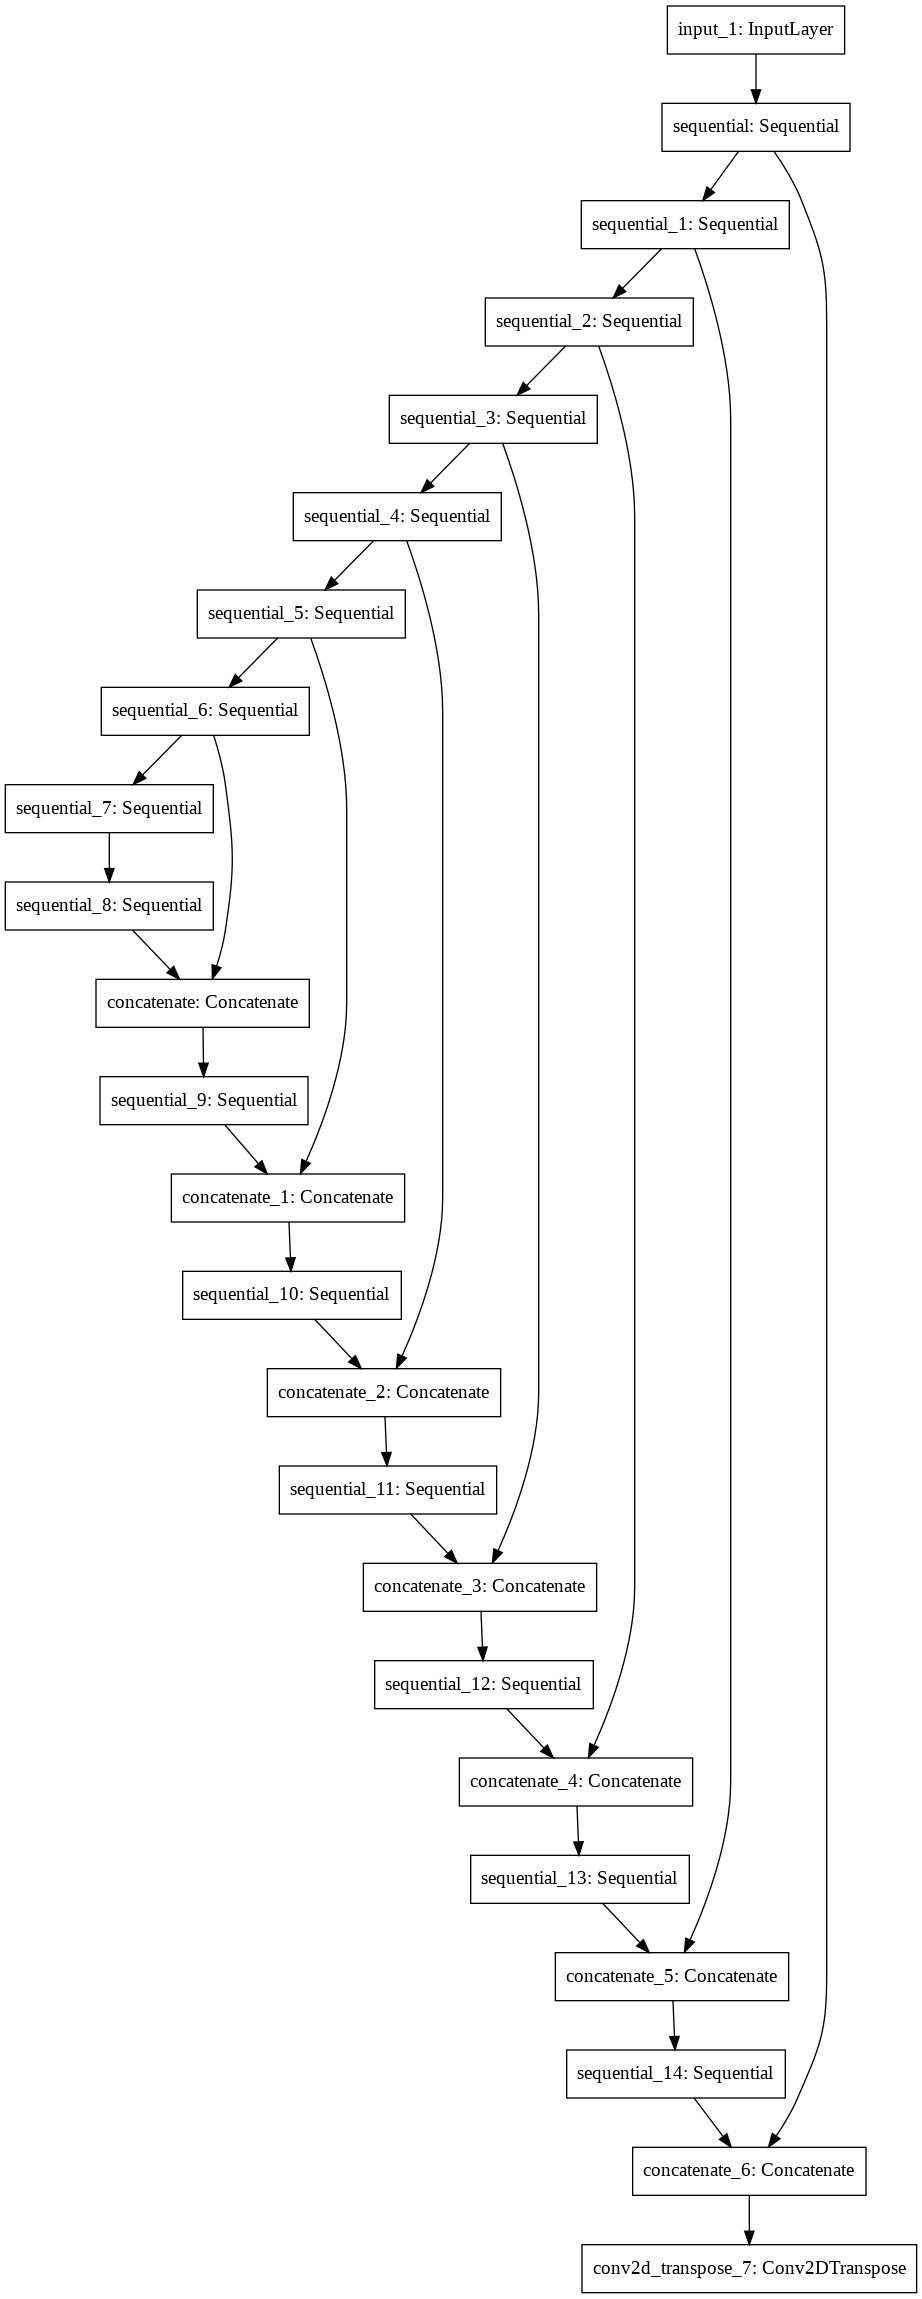

In [ ]:
# Generator ağımıza bir göz atalım
model = Generator()
plot_model(model)

In [ ]:
def Discriminator():    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

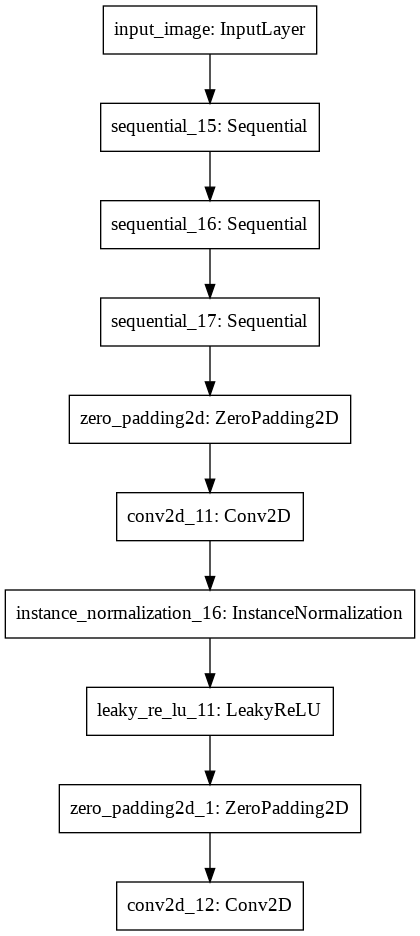

In [ ]:
del model
model = Discriminator()
plot_model(model)

In [ ]:
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

Şimdi biraz soluklanalım. 2 ağın birbiri ile çekişme halinde olduğunu tanımlamıştık. GAN ağı Ian abimizin yüksek lisans tezidir makalenin yayınlanmasından sonra çok fazla atıfta bulunulmuş, güncellenmiş, geliştirilmiş. cycleGAN'de onlardan biri. Gerçekten bir ağı tanımak için GitHub sayfalarında veya Medium gibi platformlara gerek yok arkadaşlar. Research paperlar sizleri korkutabilir ama gerçekten publish şekilde paylaştıkları gibi dil de olabildiğince sade tutuluyor asla gözünüzü korkutmasın madde madde makaleden yazılarla birkaç ipucu ile ağ mimarisini anlatıcam:

1)Adversial Loss:

>LGAN(G,DY,X,Y) =Ey∼pdata(y)[logDY(y)]+Ex∼pdata(x)[log(1−DY(G(x))]

*For the mapping function G:X→Y and its discriminator DY, we express the where G tries to generate images G(x) that look similar to images from domain Y, while DY aims to distinguish between translated samples G(x) and real samplesy. G aims to minimize this objective against an adversary D that tries to  maximize  it*

GAN mimarisi adında anlaşılacağı gibi 2 ağın çekişmesinden oluşur. Burada Adversial Loss makalede de anlatıldığı gibi G onu maksimize etmeye çalışan D'ye karşı en aza indirgemeyi amaçlar, formülde çok iyi bildiğimiz binary cross entropy.

2)Cycle Loss

*Adversarial losses alone can not guarantee that the learned function can map an individual input xi to a desired output yi.  To further reduce the space of possible mapping functions, we argue that the learned mapping functions should be cycle-consistent. For each image x from domainX, the image translation cycle should be able to bring x back to the original image ,i.e., x→G(x)→F(G(x))≈x. We call this forward cycle-consistency. Similarly, as illustrated in Figure 3 (c), foreach image y from domainY ,G and F should also satisfy backward cycle consistency:y→F(y)→G(F(y))≈y.*

Bu alıntının üst kısımlarıda önemli fakat yazı çok uzadığından dolayı almak istemedim. Ama belirtildiği gibi çekişmeli ağın kayıp fonksiyonu üretim için yeterli değil. Bu yüzden ağında adını aldığı iki ayrı loss olan forward & backward cycle-loss, yine alıntıda denildiği gibi "... etki alanı X'ten her bir görüntü x için görüntü dönüştürme döngüsü, x'i geri getirebilmelidir, yani orijinal görüntüye..." bu forward cycle-loss, "...benzer şekilde, Şekil 3 (c) 'de gösterildiği gibi, Y, G ve F alanlarından gelen her görüntü y de geri döngü tutarlılığını sağlamalıdır." ve bu da backward cycle-loss:


>Lcyc(G,F) =Ex∼pdata(x)[‖F(G(x))−x‖1]+Ey∼pdata(y)[‖G(F(y))−y‖1].

3)Full-Objective

Son loss func.'ımız ise denildiği gibi genel toplam. Burada lambda fonksiyon ağırlıklandırması ağın kullanım alanına göre değişkenlik gösteriyor. Eğer makalenin Ekler kısmana bakarsanız bizim için bu değer:

*The weight for the identity mapping loss was 0.5λ where λ was the weight for cycle consistency loss. We set λ= 10.*

>L(G,F,DX,DY) =LGAN(G,DY,X,Y)+LGAN(F,DX,Y,X)+λLcyc(G,F)

Optimizer ve learning rate için ise:

*We use the Adam with a batch size of 1. All networks were trained from scratch with a learning rate of 0.0002.*

Aslında makalede learning decay kullanılmış her 100 epochtan sonra 0'da doğru azalan fakat benim coLab de diğer projelerim için GPU kullanımında tasarrufa gittim :) ama bunu da kullanabilirsiniz.

Çok fazlasıyla uzadı yazı, zaten fazlasıyla bu konu ile alakalı kaynak olduğunu düşünüyorum, ama dediğim gibi makalelerden korkmayın arkadaşlar.














In [ ]:
# Son dokunuşlarda sıra önce sınfı oluşturalım.
class cycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10, # Lambda ağırlıklandırma parametresi 
    ):
        super(cycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(cycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Forward Cycle
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            #Backward Cycle
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            #Identity
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator ağının lossları
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Toplam Cycle Loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Toplam Generator ağının lossları
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator ağının lossları
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # 2 ağ için gradyan hesaplanması
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Gradyanlara optimizer fonksiyonlarının uygulanması
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
def discriminator_loss(real, generated):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
 return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image, LAMBDA):
 loss = tf.reduce_mean(tf.abs(real_image - same_image))
 return LAMBDA * 0.5 * loss

In [ ]:
# Loss fonkisyonları tanımladık optimizerları tanımlayalım. Değerler makaleye sadık kalınarak belirlenmiş lambda ağırlığında olduğu gibi.
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Herşey tamam compile edelim ve sonraki hücre de eğitime başlayalım.
cycleGAN_model = cycleGAN(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)
cycleGAN_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [ ]:
cycleGAN_model.fit(
    tf.data.Dataset.zip((monet, photo)),
    epochs=50
)

Epoch 1/50
600/600 [==============================] - 337s 444ms/step - monet_gen_loss: 4.3451 - photo_gen_loss: 4.4810 - monet_disc_loss: 0.6542 - photo_disc_loss: 0.6221
Epoch 2/50
600/600 [==============================] - 274s 457ms/step - monet_gen_loss: 3.5130 - photo_gen_loss: 3.6573 - monet_disc_loss: 0.6507 - photo_disc_loss: 0.6158
Epoch 3/50
600/600 [==============================] - 274s 457ms/step - monet_gen_loss: 3.2667 - photo_gen_loss: 3.3745 - monet_disc_loss: 0.6230 - photo_disc_loss: 0.6069
Epoch 4/50
600/600 [==============================] - 274s 457ms/step - monet_gen_loss: 3.2042 - photo_gen_loss: 3.2354 - monet_disc_loss: 0.6040 - photo_disc_loss: 0.6101
Epoch 5/50
600/600 [==============================] - 274s 456ms/step - monet_gen_loss: 3.1486 - photo_gen_loss: 3.1574 - monet_disc_loss: 0.6013 - photo_disc_loss: 0.6130
Epoch 6/50
600/600 [==============================] - 274s 457ms/step - monet_gen_loss: 3.0670 - photo_gen_loss: 3.0784 - monet_disc_loss: 0

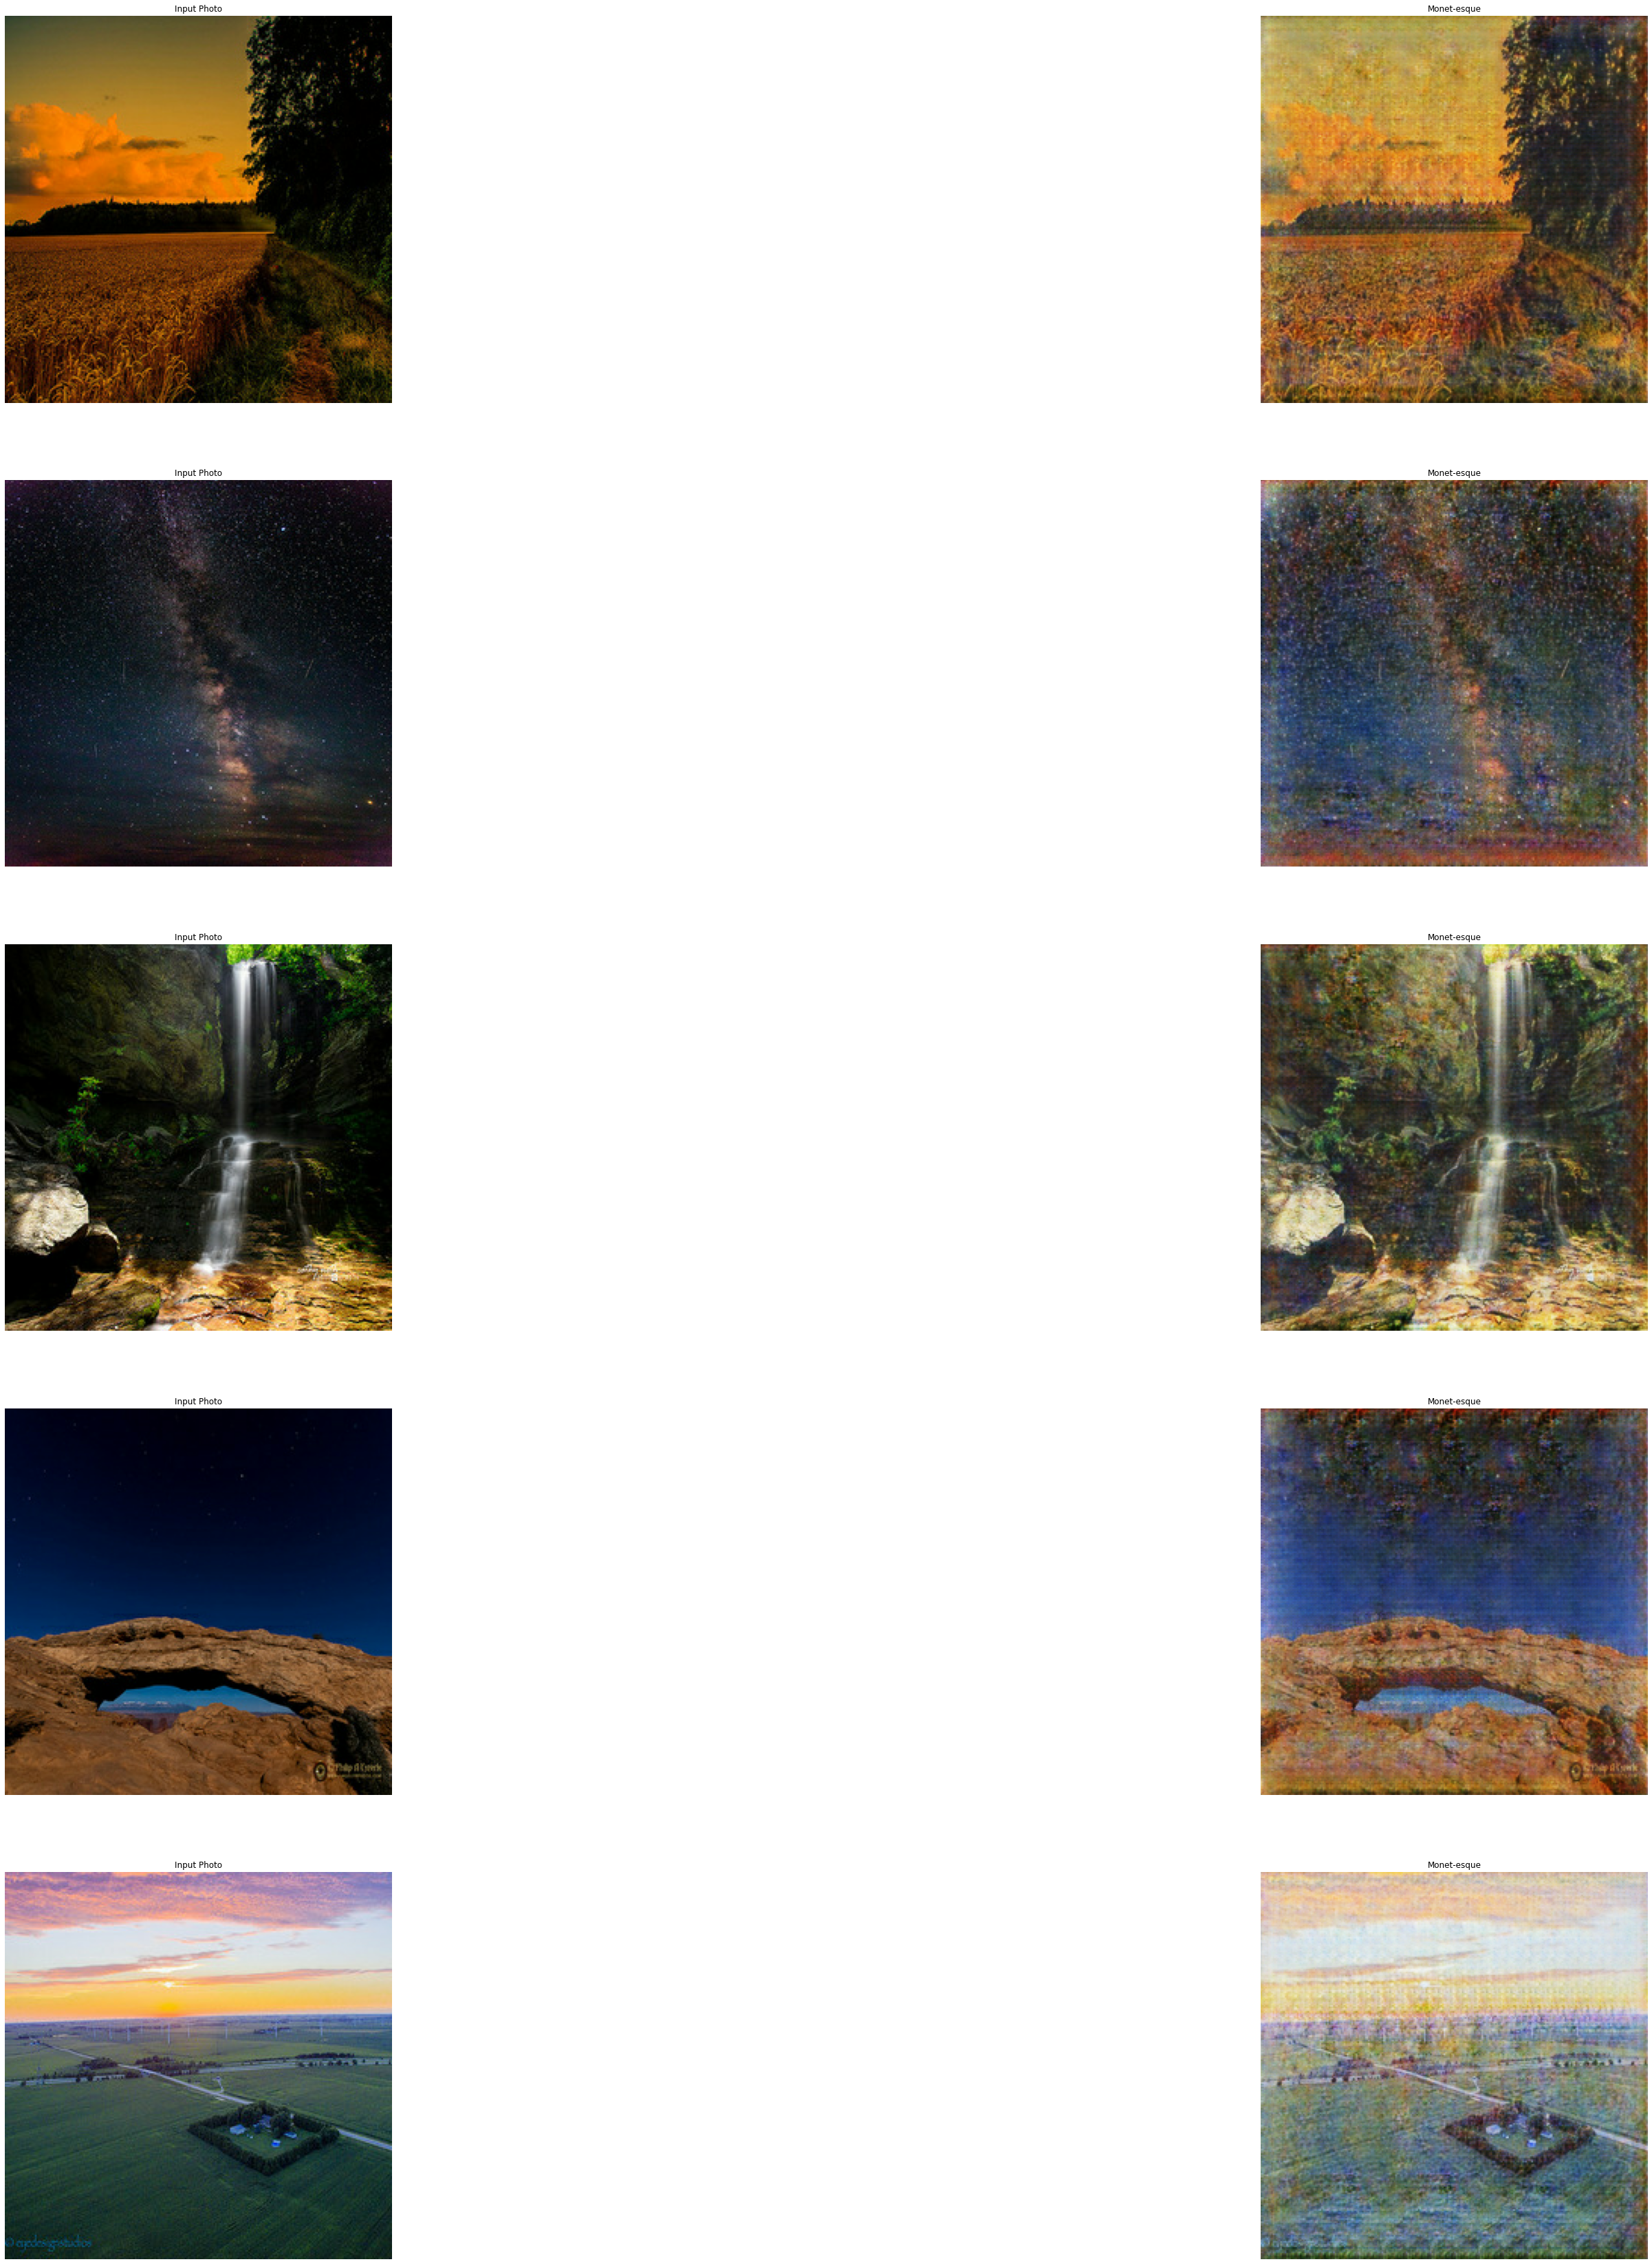

In [73]:
_, ax = plt.subplots(5, 2, figsize=(60, 60))
for i, img in enumerate(photo.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()